In [1]:
#genes found to be significant:
#total- NLGN4Y, SYN2, GNB1L, KLHL22, CLDN5, GJA8
#comm- TREM2, CHD8, SYN2, FKBP6, RTN4R, KLHL22, TBX1, GDPD3, YPEL3, DOC2A
#social- NLGN4Y, SYN2, CLDN5, KLHL22, GNB1L, GJA8
#rrb- CDC45, AIFM3, TXNRD2, QPRT

In [2]:
import pandas as pd
from sklearn import linear_model
import numpy as np
from matplotlib import pyplot as plt
import ants
import os
from tqdm import tqdm
import statistics
import statsmodels.api as sm

In [18]:
cd ../../Data/Genemaps

/mmfs1/data/pijarj/BC-ORG-Data/Data/Genemaps


In [19]:
#read in symptom patient data and slice out important columns
df = pd.read_csv('/mmfs1/data/pijarj/Data4Julianna/df_patients_S699.csv')
df.columns
df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']]

,ados_total,ados_comm,ados_social,ados_rrb
0,18.0,6.0,12.0,2.0
1,NaN,NaN,NaN,NaN
2,13.0,4.0,9.0,NaN
3,12.0,4.0,8.0,2.0
4,16.0,5.0,11.0,3.0
...,...,...,...,...
694,NaN,NaN,NaN,NaN
695,NaN,NaN,NaN,NaN
696,13.0,4.0,9.0,2.0
697,8.0,2.0,6.0,2.0


In [20]:
#load in diffmat data
atlas = ants.image_read('../../YeoAtlas/Atlas_parc-7n_2mm.nii')
diffmat = np.load('/mmfs1/data/pijarj/Data4Julianna/recon_asd_diffmats.npz')
diffmat = diffmat['data']
diffmat.shape

(699, 51, 51)

In [21]:
genemaps = [file for file in os.listdir() if file.endswith('.nii.gz')]
genemaps.sort()

In [22]:
nsubjects = 699
ngenes = len(genemaps)
print(nsubjects)
print(ngenes)

gene_fmri_corr = np.zeros((ngenes,nsubjects))
gene_fmri_corr

699
18


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
for g in tqdm(range(ngenes)):
    gene_im = ants.image_read(genemaps[g])
    gene_flat = gene_im.numpy().flatten()
    atlas_flat = atlas.numpy().flatten()
    roi_expression = np.array([gene_flat[atlas_flat==roi].mean() for roi in np.arange(1,52)])
    gene_sim = np.zeros((51,51))
    for i in range(51):
        for j in range(51):
            gene_sim[i,j] = abs(roi_expression[i]-roi_expression[j])

    triu = np.triu_indices(51,k=1)
    gene_vec = gene_sim[triu]

    for s in range(nsubjects):
        subject_diffmat = diffmat[s,:,:] # correlation matrices for one subject
        fmri_vec = subject_diffmat[triu]
        data = np.corrcoef(gene_vec,fmri_vec)[0,1]
        gene_fmri_corr[g,s] = data

100%|██████████| 18/18 [00:02<00:00,  8.96it/s]


(18, 699)

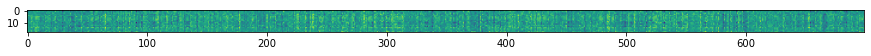

In [25]:
plt.figure(figsize=(15,10))
plt.imshow(gene_fmri_corr)
gene_fmri_corr.shape

In [26]:
col_id = 0
Y_total = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_total = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_total = ~np.isnan(Y_total)[:,col_id]
Y_use_total = Y_total[good_subjects_total,col_id] 
X_use_total = gene_fmri_corr[:,good_subjects_total]
X_use_total = X_use_total.transpose()
regression_total =  linear_model.LinearRegression(normalize=True)
linear_regression_total = regression_total.fit(X_use_total,Y_use_total) 
Y_use_hat_total = linear_regression_total.predict(X_use_total)

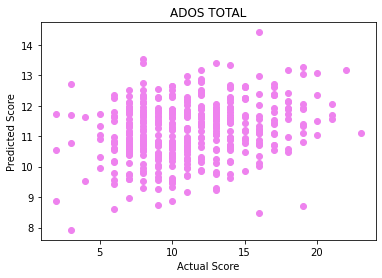

In [28]:
#scatter plot for ados_total
plt.scatter(Y_use_total,Y_use_hat_total,color='violet')
plt.title('ADOS TOTAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [29]:
col_id = 1
Y_comm = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_comm = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_comm = ~np.isnan(Y_comm)[:,col_id]
Y_use_comm = Y_comm[good_subjects_comm,col_id] 
X_use_comm = gene_fmri_corr[:,good_subjects_comm]
X_use_comm = X_use_comm.transpose()
regression_comm =  linear_model.LinearRegression(normalize=True)
linear_regression_comm = regression_comm.fit(X_use_comm,Y_use_comm) 
Y_use_hat_comm = linear_regression_comm.predict(X_use_comm)

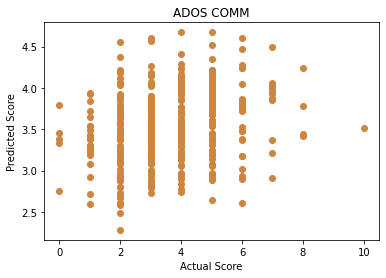

In [31]:
#scatter plot for ados_comm
plt.scatter(Y_use_comm,Y_use_hat_comm,color='peru')
plt.title('ADOS COMM')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [32]:
col_id = 2
Y_social = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_social = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_social = ~np.isnan(Y_social)[:,col_id]
Y_use_social = Y_social[good_subjects_social,col_id] 
X_use_social = gene_fmri_corr[:,good_subjects_social]
X_use_social = X_use_social.transpose()
regression_social =  linear_model.LinearRegression(normalize=True)
linear_regression_social = regression_social.fit(X_use_social,Y_use_social) 
Y_use_hat_social = linear_regression_social.predict(X_use_social)

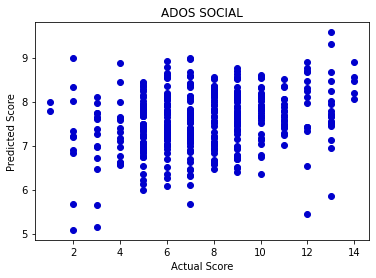

In [33]:
#scatter plot for ados_social
plt.scatter(Y_use_social,Y_use_hat_social,color='mediumblue')
plt.title('ADOS SOCIAL')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [34]:
col_id = 3
Y_rrb = df[['ados_total', 'ados_comm', 'ados_social', 'ados_rrb']].values
column_rrb = (['ados_total', 'ados_comm', 'ados_social', 'ados_rrb'][col_id])
good_subjects_rrb = ~np.isnan(Y_rrb)[:,col_id]
Y_use_rrb = Y_rrb[good_subjects_rrb,col_id] 
X_use_rrb = gene_fmri_corr[:,good_subjects_rrb]
X_use_rrb = X_use_rrb.transpose()
regression_rrb =  linear_model.LinearRegression(normalize=True)
linear_regression_rrb = regression_rrb.fit(X_use_rrb,Y_use_rrb) 
Y_use_hat_rrb = linear_regression_rrb.predict(X_use_rrb)

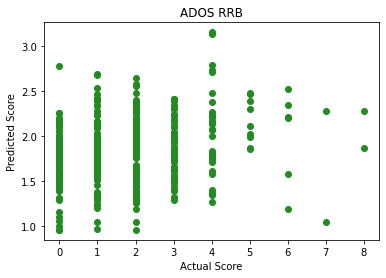

In [35]:
#scatter plot for ados_rrb
plt.scatter(Y_use_rrb,Y_use_hat_rrb,color='forestgreen')
plt.title('ADOS RRB')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

In [36]:
#variance explained for ados_total
from sklearn.metrics import explained_variance_score
total = explained_variance_score(Y_use_total,Y_use_hat_total)*100
print(total)

6.024568105760708


In [37]:
#variance explained for ados_comm
from sklearn.metrics import explained_variance_score
comm = explained_variance_score(Y_use_comm,Y_use_hat_comm)*100
print(comm)

7.304929665233917


In [38]:
#variance explained for ados_social
from sklearn.metrics import explained_variance_score
social = explained_variance_score(Y_use_social,Y_use_hat_social)*100
print(social)

6.332523981503235


In [39]:
#variance explained for ados_rrb
from sklearn.metrics import explained_variance_score
rrb = explained_variance_score(Y_use_rrb,Y_use_hat_rrb)*100
print(rrb)

5.708875774119393


Text(0.5, 0, 'Symptom')

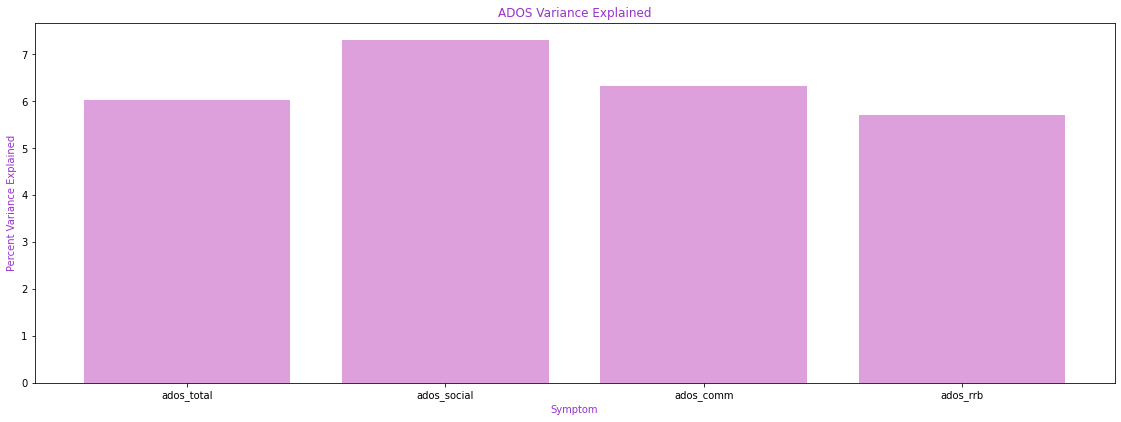

In [41]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ados_label = ['ados_total','ados_social','ados_comm','ados_rrb']
var_explained = total, comm, social, rrb
plt.bar(ados_label,var_explained,color='plum')
plt.title('ADOS Variance Explained',color='darkorchid')
plt.ylabel('Percent Variance Explained',color='darkorchid')
plt.xlabel('Symptom',color='darkorchid')

In [42]:
#correlation coefficents for ados_total
coefficient_total = regression_total.coef_
labels = ['TXNRD2','NLGN4Y','GJA8','TREM2','GNB1L','CHD8','RTN4R','GDPD3','YPEL3','KLHL22','CDKL5','SYN2','TBX1','CLDN5','AIFM3','CDC45','DOC2A','FKBP6']
print(column_total)
print()
for i in range(0,ngenes):
    print(f'{labels[i]},{coefficient_total[i]}')

ados_total

TXNRD2,6.950986650870845
NLGN4Y,-10.047847997853408
GJA8,2.5445606489710237
TREM2,-5.298577303570369
GNB1L,9.514347925205739
CHD8,5.497445221334543
RTN4R,4.80279016844002
GDPD3,4.379189789525735
YPEL3,3.44602622832094
KLHL22,-11.748417411053206
CDKL5,-3.8436489706578723
SYN2,3.846810852739239
TBX1,-6.203197202450035
CLDN5,7.611834842606618
AIFM3,-4.464347662617907
CDC45,-5.099880961643837
DOC2A,1.6771321309685479
FKBP6,-2.98512266986891


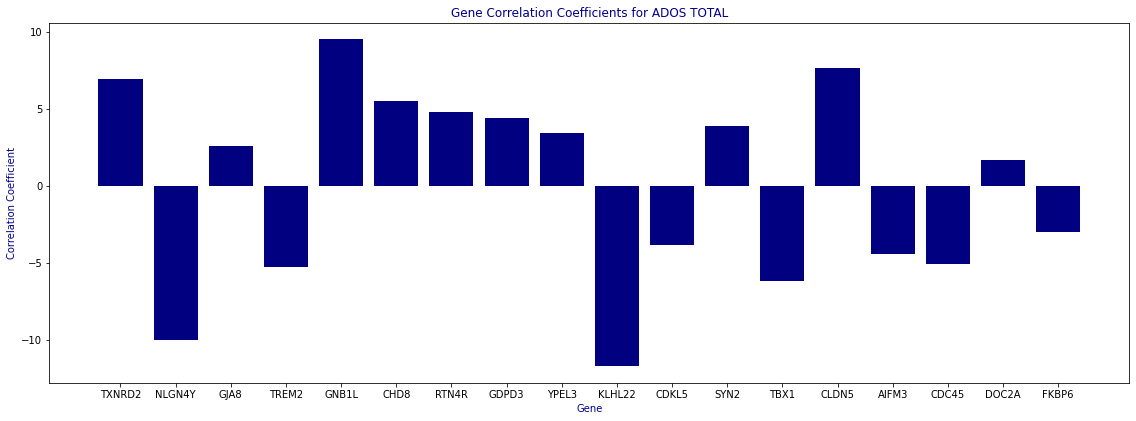

In [45]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_total,color='navy')
plt.title('Gene Correlation Coefficients for ADOS TOTAL',color='darkblue')
plt.ylabel('Correlation Coefficient',color='darkblue')
plt.xlabel('Gene',color='darkblue')
plt.show()

In [46]:
#correlation coefficents for ados_comm
coefficient_comm = regression_comm.coef_
print(column_comm)
print()
for i in range(0,ngenes):
    print(f'{labels[i]},{coefficient_comm[i]}')

ados_comm

TXNRD2,4.310648173972325
NLGN4Y,-1.7579722367430415
GJA8,-0.7882856723832629
TREM2,-4.207959568582795
GNB1L,2.9332832422498716
CHD8,1.848106613428514
RTN4R,4.732388822118036
GDPD3,0.7640583581723494
YPEL3,2.699306668942621
KLHL22,-6.34251194601049
CDKL5,-1.3542652916072468
SYN2,3.054271314879081
TBX1,-4.666689750389139
CLDN5,3.4300381109912785
AIFM3,-1.457224084209942
CDC45,-1.3023074104568388
DOC2A,-0.7079598318536249
FKBP6,0.13759040594004146


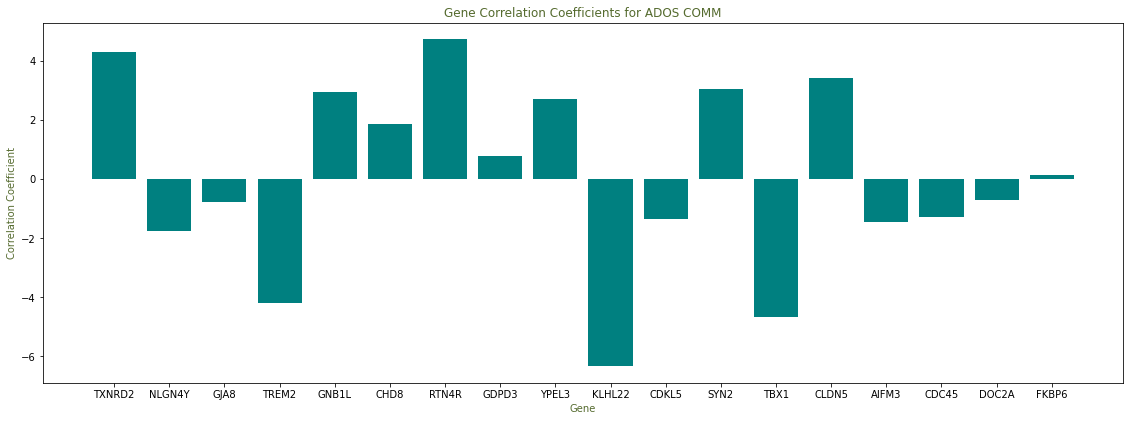

In [48]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_comm,color='teal')
plt.title('Gene Correlation Coefficients for ADOS COMM',color='darkolivegreen')
plt.ylabel('Correlation Coefficient',color='darkolivegreen')
plt.xlabel('Gene',color='darkolivegreen')
plt.show()

In [49]:
#correlation coefficents for ados_social
coefficient_social = regression_social.coef_
print(column_social)
print()
for i in range(0,ngenes):
    print(f'{labels[i]},{coefficient_social[i]}')

ados_social

TXNRD2,2.586031036205942
NLGN4Y,-6.072889165970711
GJA8,4.175806548741746
TREM2,-2.257048915078679
GNB1L,9.65747895424485
CHD8,2.908261470537039
RTN4R,0.9515678187671388
GDPD3,2.302054671074676
YPEL3,0.4725311073989467
KLHL22,-6.783341568682148
CDKL5,-3.9159276753706247
SYN2,0.8433948409050612
TBX1,-1.7322067143055964
CLDN5,5.315183897902044
AIFM3,-2.227560488084278
CDC45,-4.035202346349177
DOC2A,2.578325313586569
FKBP6,-3.7156052684389675


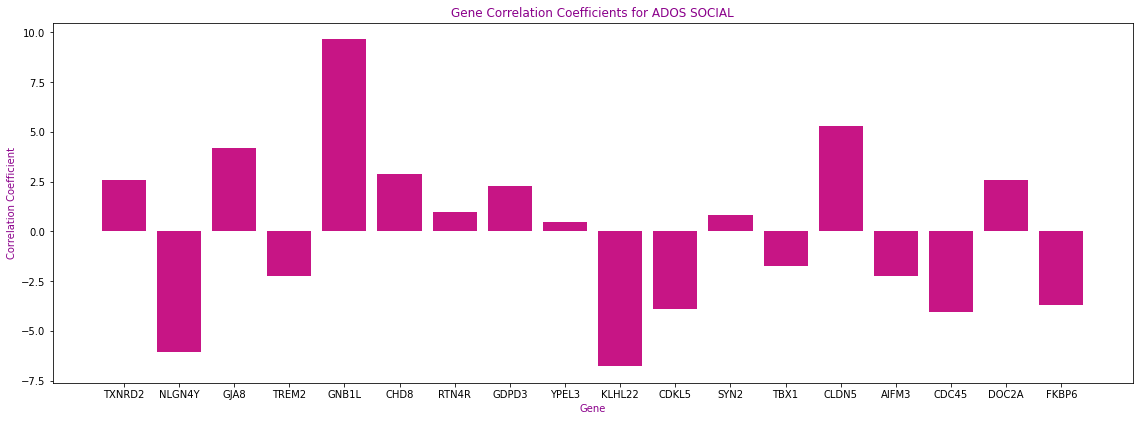

In [52]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_social,color='mediumvioletred')
plt.title('Gene Correlation Coefficients for ADOS SOCIAL',color='darkmagenta')
plt.ylabel('Correlation Coefficient',color='darkmagenta')
plt.xlabel('Gene',color='darkmagenta')
plt.show()

In [53]:
#correlation coefficents for ados_rrb
coefficient_rrb = regression_rrb.coef_
print(column_rrb)
print()
for i in range(0,ngenes):
    print(f'{labels[i]},{coefficient_rrb[i]}')

ados_rrb

TXNRD2,4.381817887141267
NLGN4Y,-4.855582380874578
GJA8,-0.698250558960132
TREM2,2.3199515736934697
GNB1L,1.3634311577799243
CHD8,-4.815485620241955
RTN4R,-5.143729214139321
GDPD3,1.8245111452567808
YPEL3,0.033601817752939446
KLHL22,0.3072363342644887
CDKL5,0.9754631406926683
SYN2,-1.9305040360811965
TBX1,-4.5191816883577305
CLDN5,1.802568361654495
AIFM3,5.217811742746492
CDC45,-2.5396422365601725
DOC2A,4.129099711312306
FKBP6,-2.0084948367725057


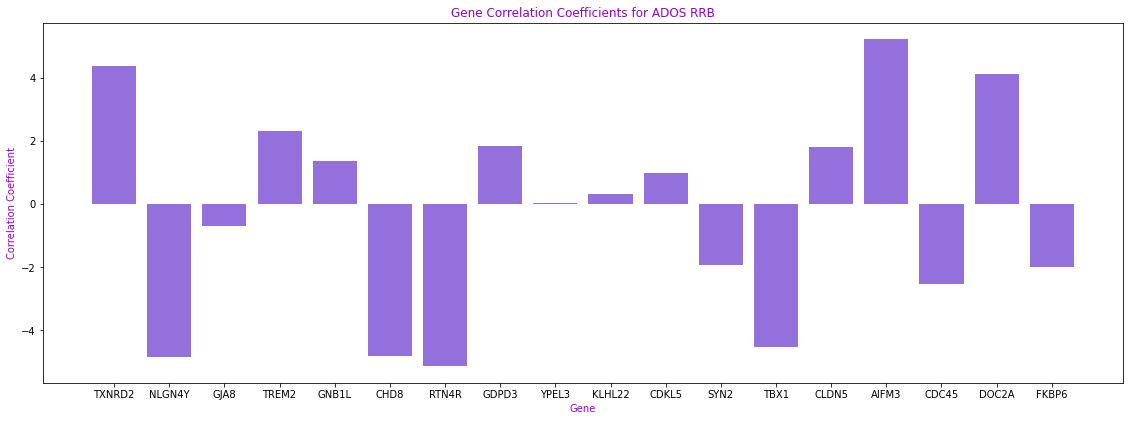

In [54]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
plt.bar(labels,coefficient_rrb,color='mediumpurple')
plt.title('Gene Correlation Coefficients for ADOS RRB',color='darkviolet')
plt.ylabel('Correlation Coefficient',color='darkviolet')
plt.xlabel('Gene',color='darkviolet')
plt.show()

In [55]:
#significance of coefficients for ados_total
print('ADOS_TOTAL')
X_total = X_use_total.copy()
Y_total = Y_use_total.copy()
X_total = sm.add_constant(X_total)
print(X_total.shape)
print(Y_total.shape)

est_total = sm.OLS(Y_total, X_total)
est2_total = est_total.fit()
print(est2_total.summary())

ADOS_TOTAL
(429, 19)
(429,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.460
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.100
Time:                        13:53:38   Log-Likelihood:                -1176.5
No. Observations:                 429   AIC:                             2391.
Df Residuals:                     410   BIC:                             2468.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8390   

In [56]:
def plot_errorbar_from_table(est2_total,labels):
    coef_total = est2_total.params[1::]
    ci_total = est2_total.conf_int()[1::,:]
    ci_rel_total = abs(np.vstack((coef_total,coef_total)).transpose() - ci_total)
    ci_rel_total = ci_rel_total.transpose()
    xs_total = np.arange(len(coef_total))

    plt.figure(figsize=(15,5))
    plt.bar(xs_total,coef_total,color='thistle')
    plt.errorbar(xs_total,coef_total,ci_rel_total,fmt='r ',capsize=10,ecolor='indigo')
    plt.xticks(xs_total,labels=labels);

Text(0.5, 0, 'Gene')

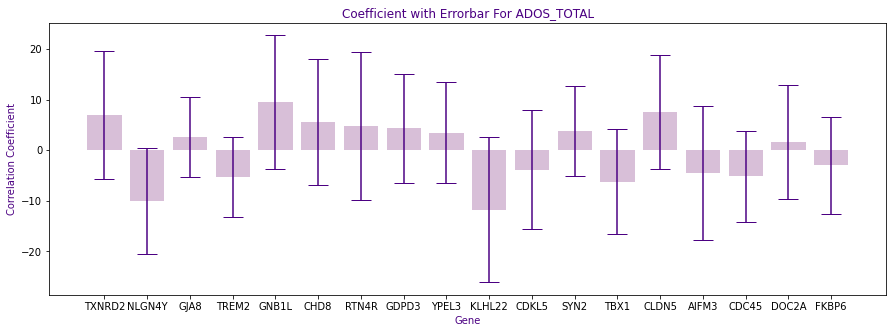

In [57]:
plot_errorbar_from_table(est2_total,labels)
plt.title('Coefficient with Errorbar For ADOS_TOTAL',color='indigo')
plt.ylabel('Correlation Coefficient',color='indigo')
plt.xlabel('Gene',color='indigo')

In [58]:
#significance of coefficients for ados_comm
print('ADOS_COMM')
X_comm = X_use_comm.copy()
Y_comm = Y_use_comm.copy()
X_comm = sm.add_constant(X_comm)

est_comm = sm.OLS(Y_comm, X_comm)
est2_comm = est_comm.fit()
print(est2_comm.summary())

ADOS_COMM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.716
Date:                Mon, 07 Nov 2022   Prob (F-statistic):             0.0343
Time:                        13:54:17   Log-Likelihood:                -759.03
No. Observations:                 411   AIC:                             1556.
Df Residuals:                     392   BIC:                             1632.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3780      0.107     31.45

In [64]:
def plot_errorbar_from_table(est2_comm,labels):
    coef_comm = est2_comm.params[1::]
    ci_comm = est2_comm.conf_int()[1::,:]
    ci_rel_comm = abs(np.vstack((coef_comm,coef_comm)).transpose() - ci_comm)
    ci_rel_comm = ci_rel_comm.transpose()
    xs_comm = np.arange(len(coef_comm))

    plt.figure(figsize=(15,5))
    plt.bar(xs_comm,coef_comm,color='tan')
    plt.errorbar(xs_comm,coef_comm,ci_rel_comm,fmt='r ',capsize=10,ecolor='saddlebrown')
    plt.xticks(xs_comm,labels=labels);

Text(0.5, 0, 'Gene')

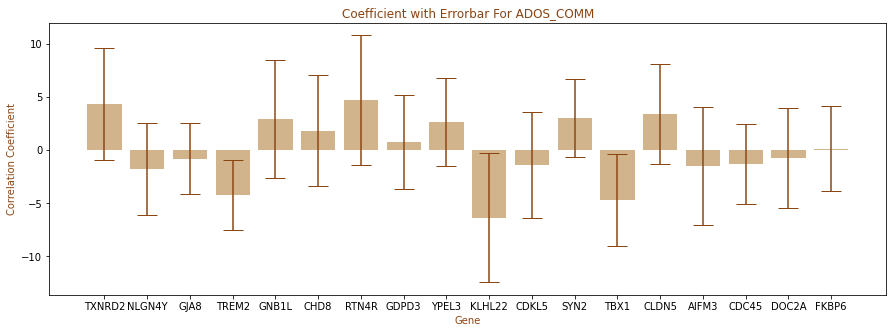

In [65]:
plot_errorbar_from_table(est2_comm,labels)
plt.title('Coefficient with Errorbar For ADOS_COMM',color='saddlebrown')
plt.ylabel('Correlation Coefficient',color='saddlebrown')
plt.xlabel('Gene',color='saddlebrown')

In [66]:
#significance of coefficients for ados_social
print('ADOS_SOCIAL')
X_social = X_use_social.copy()
Y_social = Y_use_social.copy()
X_social = sm.add_constant(X_social)

est_social = sm.OLS(Y_social, X_social)
est2_social = est_social.fit()
print(est2_social.summary())

ADOS_SOCIAL
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.476
Date:                Mon, 07 Nov 2022   Prob (F-statistic):             0.0947
Time:                        13:55:19   Log-Likelihood:                -984.79
No. Observations:                 412   AIC:                             2008.
Df Residuals:                     393   BIC:                             2084.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3284      0.185     39.

In [68]:
def plot_errorbar_from_table(est2_social,labels):
    coef_social = est2_social.params[1::]
    ci_social = est2_social.conf_int()[1::,:]
    ci_rel_social = abs(np.vstack((coef_social,coef_social)).transpose() - ci_social)
    ci_rel_social = ci_rel_social.transpose()
    xs_social = np.arange(len(coef_social))

    plt.figure(figsize=(15,5))
    plt.bar(xs_social,coef_social,color='skyblue')
    plt.errorbar(xs_social,coef_social,ci_rel_social,fmt='r ',capsize=10,ecolor='steelblue')
    plt.xticks(xs_social,labels=labels);

Text(0.5, 0, 'Gene')

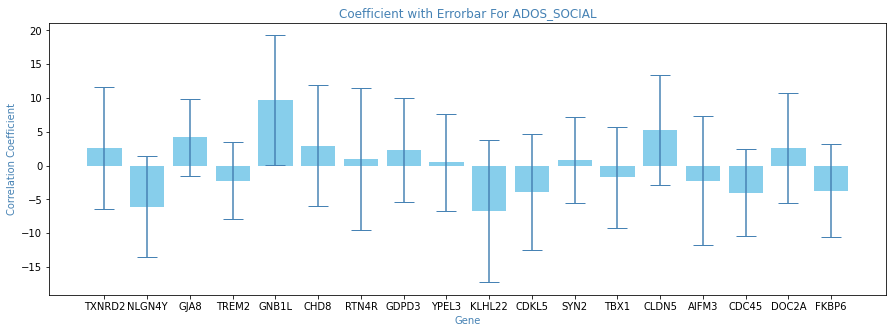

In [69]:
plot_errorbar_from_table(est2_social,labels)
plt.title('Coefficient with Errorbar For ADOS_SOCIAL',color='steelblue')
plt.ylabel('Correlation Coefficient',color='steelblue')
plt.xlabel('Gene',color='steelblue')

In [70]:
#significance of coefficients for ados_rrb
print('ADOS_RRB')
X_rrb = X_use_rrb.copy()
Y_rrb = Y_use_rrb.copy()
X_rrb = sm.add_constant(X_rrb)

est_rrb = sm.OLS(Y_rrb, X_rrb)
est2_rrb = est_rrb.fit()
print(est2_rrb.summary())

ADOS_RRB
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.197
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.260
Time:                        13:55:52   Log-Likelihood:                -680.23
No. Observations:                 375   AIC:                             1398.
Df Residuals:                     356   BIC:                             1473.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8833      0.109     17.348

In [93]:
def plot_errorbar_from_table(est2_rrb,labels):
    coef_rrb = est2_rrb.params[1::]
    ci_rrb = est2_rrb.conf_int()[1::,:]
    ci_rel_rrb = abs(np.vstack((coef_rrb,coef_rrb)).transpose() - ci_rrb)
    ci_rel_rrb = ci_rel_rrb.transpose()
    xs_rrb = np.arange(len(coef_rrb))

    plt.figure(figsize=(15,5))
    plt.bar(xs_rrb,coef_rrb,color='mediumaquamarine')
    plt.errorbar(xs_rrb,coef_rrb,ci_rel_rrb,fmt='r ',capsize=10,ecolor='darkgreen')
    plt.xticks(xs_rrb,labels=labels);

Text(0.5, 0, 'Gene')

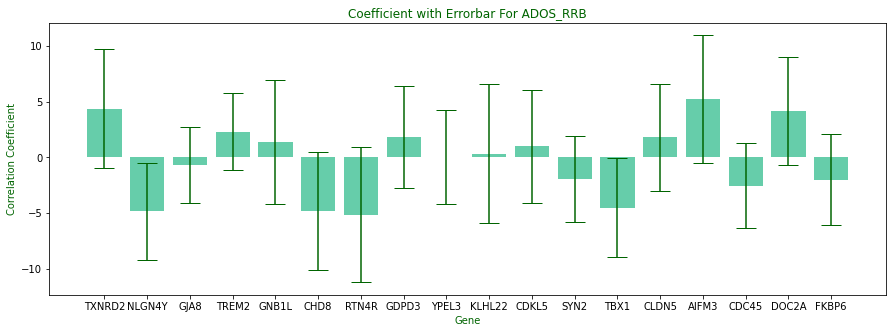

In [95]:
plot_errorbar_from_table(est2_rrb,labels)
plt.title('Coefficient with Errorbar For ADOS_RRB',color='darkgreen')
plt.ylabel('Correlation Coefficient',color='darkgreen')
plt.xlabel('Gene',color='darkgreen')